# GLM Demo: multivariate song stimulus, biophysical dynamics

This demo simulates responses to song using a linear-dynamical cascade model. It's like the first demo, but the stimulus is song and there are multiple spectral bands.

In [1]:
from __future__ import print_function, division
import os
import sys
import numpy as np

import mat_neuron._model as mat
from dstrf import io, strf, mle, simulate, data, filters, models, spikes, performance

# plotting packages
%reload_ext yamlmagic
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

cfg = {}

Set up parameters using YAML and Munch

In [7]:
%%yaml cfg
model:
  dt: 0.5
  ataus: [10.0, 200.0]
  t_refract: 2.0
  filter:
    rank: 2
    len: 50
    ncos: 12
  prior:
#     l1: 14.61
#     l2: 1.62
    l1: 585.0558005127248
    l2: 30.792410553301334
data:
  source: "wavefiles"
  root: "../../zf_songs"
  stimulus:
    spectrogram:
      window: 2.5
      compress: 10
      f_min: 1.0
      f_max: 8.0
      f_count: 20
      gammatone: True
  model: "multivariate_dynamical"
  dynamics:
    model: "../../models/phasic.yml"
    current_scaling: 4.0
    current_compression:
      intercept: -1.32215976
      slope: 0.04068182
      V_lower: -100
      V_upper: 0
    current_recenter: 1.0
  filter:
    # the hg_dstrf filter function loads parameters from a file; select which row to use with `rf`
    fn: "hg_dstrf"
    paramfile: "../../config/hg_filters.csv"
    rf: 2
    nfreq: 20
    ntau: 50
    t_max: 50
    ampl: 1.0
    f_max: 8
    Pf: 0.0
  trial_noise:
    color: pink
    snr: 4
    random_seed: 1049
  dt: 1.0
  trials: 3
  test_proportion: 0.2
spike_detect:
  thresh: -20.0
  rise_dt: 1.0
emcee:
  nsteps: 10
  nthreads: 8
  nwalkers: 500
  startpos_scale: 2.0
  bounds:
  - [0, 20]
  - [-50, 800]
  - [-5, 10]  

<IPython.core.display.Javascript object>

In [8]:
from munch import munchify
cf = munchify(cfg)

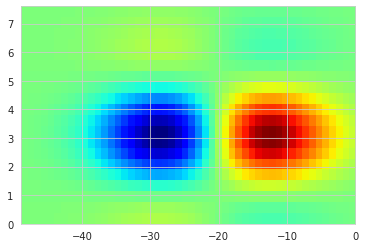

In [9]:
k1, k1t, k1f = simulate.get_filter(cf)
plt.imshow(k1, extent=(k1t[0], k1t[-1], k1f[0], k1f[-1]), cmap='jet', aspect='auto');

The simulation code has been factored out to the `simulate` module. We're going to split the data into assimilation and test sets.

In [10]:
stim_data = data.wavefiles(cf)
n_test = int(cf.data.test_proportion * len(stim_data))
assim_data = io.merge_data(simulate.multivariate_dynamical(cf, stim_data[:-n_test]))

simulating responses using linear-dynamical cascade model
 - stimulus dimension: 20
 - convolution output will be recentered
 - convolution output will be compressed
 - dynamical model: ../../models/phasic.yml
 - conductances: g_l, g_hcn, g_kht, g_klt, g_na, g_ka


In [11]:
print("duration:", assim_data["duration"])
print("stim bins:", assim_data["stim"].shape[1])
print("spike bins:", assim_data["spike_v"].shape[0])
print("I_max:", np.max(assim_data["I"]))
print("I_rms:", np.sqrt((assim_data["I"] ** 2).mean()))
print("total spikes:", np.sum(assim_data["spike_v"]))
print("avg spike rate:", 1000 * np.sum(assim_data["spike_v"]) / assim_data["duration"] / assim_data["spike_v"].shape[1])

duration: 50952.0
stim bins: 50952
spike bins: 101904
I_max: 97.49999999999977
I_rms: 60.55995585153102
total spikes: 948
avg spike rate: 6.2019155283403995


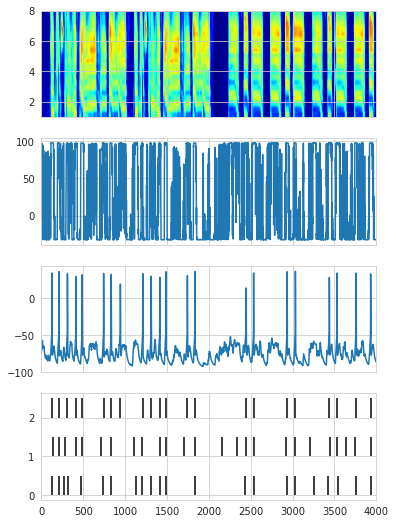

In [12]:
t_stim = np.linspace(0, assim_data["duration"], assim_data["stim"].shape[1])
t_spike = np.linspace(0, assim_data["duration"], assim_data["spike_v"].shape[0])

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6, 9))
axes[0].imshow(assim_data["stim"], 
               extent=(0, assim_data["duration"], cf.data.stimulus.spectrogram.f_min, cf.data.stimulus.spectrogram.f_max),
               cmap='jet', origin='lower', aspect='auto')
axes[1].plot(t_stim, assim_data["I"])
axes[2].plot(t_spike, assim_data["V"])
for i, spk in enumerate(assim_data["spike_t"]):
    axes[3].vlines(spk * cf.model.dt, i, i + 0.5)

axes[0].set_xlim(0, 4000);

## Estimate parameters

Uncomment the next cell if you want to use the full-rank estimator.

In [13]:
# kcosbas = strf.cosbasis(cf.model.filter.len, cf.model.filter.ncos)
# try:
#     mlest = mle.mat(assim_data["stim"], kcosbas, assim_data["spike_v"], assim_data["spike_h"],
#                         assim_data["stim_dt"], assim_data["spike_dt"])
# except TypeError:
#     mlest = mle.mat(assim_data["stim"], kcosbas, assim_data["spike_v"], assim_data["spike_h"],
#                         assim_data["stim_dt"], assim_data["spike_dt"])  

This cell constructs the reduced-rank (factorized) estimator.

In [14]:
# initial guess of parameters using ML
krank = cf.model.filter.rank
kcosbas = strf.cosbasis(cf.model.filter.len, cf.model.filter.ncos)
try:
    mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"])
except TypeError:
    mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"])    

The reg_alpha and reg_lambda parameters set the L1 and L2 penalties for elastic-net regularization. As in the previous demo, we're just going to pick some reasonable values. You'll need to use the `assimilate.py` script if you want to use cross-validation to find the optimal values.

In [15]:
%time w0 = mlest.estimate(reg_lambda=cf.model.prior.l2, reg_alpha=cf.model.prior.l1)

CPU times: user 9min 42s, sys: 1.39 s, total: 9min 44s
Wall time: 10min 4s


In [ ]:
print("MLE rate and adaptation parameters:", w0[:3])
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 6))

k1c = strf.to_basis(k1, kcosbas)
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.from_basis(strf.defactorize(w0[3:], cf.data.filter.nfreq, krank), kcosbas)
#rf_mle = strf.as_matrix(w0[3:], kcosbas)
axes[0, 0].imshow(k1, cmap='jet', aspect='auto')
axes[0, 0].set_title("True RF")
axes[0, 1].imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
axes[0, 1].set_title("RF from cosine basis")
axes[1, 0].imshow(rf_sta, cmap='jet', aspect='auto')
axes[1, 0].set_title("STA")
axes[1, 1].imshow(rf_mle, cmap='jet', aspect='auto')
axes[1, 1].set_title("MLE (rank-{})".format(krank));

In [ ]:
# plot the factors of the estimate directly
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6, 3))

k1ff, k1ft = strf.factorize(k1, 1)
km, kmt = filters.exponential(46, 1.0, cf.model.filter.len * cf.data.dt, cf.data.dt)
kconv = np.convolve(km[::-1], k1ft[0,::-1], mode="full")[:km.size][::-1]
kconv *= k1ft.max() / kconv.max()

axes[0].plot(k1t, k1ft[0], label="true")
axes[0].plot(k1t, kconv, label="expected")
axes[1].plot(k1f, k1ff[:, 0], label="true")

k_f, k_t = strf.unpack_factors(w0[3:], cf.data.filter.nfreq, krank)
k_t = strf.from_basis(k_t, kcosbas)
axes[0].plot(k1t, k_t[0], 'k', label="MLE")
axes[1].plot(k1f, k_f[:, 0], 'k', label="MLE")

We're now going to select regularization parameters using cross-validation. This makes use of the scikit-learn package.

In [ ]:
import progressbar
from dstrf import crossvalidate

#reg_grid = np.logspace(-1, 5, 50)[::-1]
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95]
reg_grid = np.logspace(-1, 5, 20)[::-1]
scores = []
results = []

bar = progressbar.ProgressBar(max_value=len(l1_ratios) * len(reg_grid),
                              widgets=[
                                ' [', progressbar.Timer(), '] ',
                                progressbar.Bar(),
                                ' (', progressbar.ETA(), ') ',
                            ])
for reg, s, w in bar(crossvalidate.elasticnet(mlest, 4, reg_grid, l1_ratios, avextol=1e-5, disp=False)):
    scores.append(s)
    results.append((reg, s, w))
    
best_idx = np.argmax(scores)
(rf_alpha, rf_lambda), ll, w0 = results[best_idx]

In [ ]:
print("best regularization params: alpha={}, lambda={}".format(rf_alpha, rf_lambda))
print("MLE rate and adaptation parameters:", w0[:3])
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 6))

k1c = strf.to_basis(k1, kcosbas)
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.from_basis(strf.defactorize(w0[3:], cf.data.filter.nfreq, krank), kcosbas)
axes[0, 0].imshow(k1, cmap='jet', aspect='auto')
axes[0, 0].set_title("True RF")
axes[0, 1].imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
axes[0, 1].set_title("RF from cosine basis")
axes[1, 0].imshow(rf_sta, cmap='jet', aspect='auto')
axes[1, 0].set_title("STA")
axes[1, 1].imshow(rf_mle, cmap='jet', aspect='auto')
axes[1, 1].set_title("MLE (rank-{})".format(krank));

## Predict responses

In [ ]:
test_data = io.merge_data(simulate.multivariate_dynamical(cf, stim_data[-n_test:], trials=50))
mltest = mle.matfact(test_data["stim"], kcosbas, krank, test_data["spike_v"], test_data["spike_h"],
                     test_data["stim_dt"], test_data["spike_dt"])

In [ ]:
print("duration:", test_data["duration"])
print("stim bins:", test_data["stim"].shape[1])
print("spike bins:", test_data["spike_v"].shape[0])
print("I_max:", np.max(test_data["I"]))
print("I_rms:", np.sqrt((test_data["I"] ** 2).mean()))
print("total spikes:", np.sum(test_data["spike_v"]))

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6, 9))
axes[0].imshow(test_data["stim"], 
               extent=(0, test_data["duration"], cf.data.stimulus.spectrogram.f_min, cf.data.stimulus.spectrogram.f_max),
               cmap='jet', origin='lower', aspect='auto')

t_stim = np.linspace(0, test_data["duration"], test_data["stim"].shape[1])
t_spike = np.linspace(0, test_data["duration"], test_data["spike_v"].shape[0])
#V = strf.convolve(test_data["stim"], k1)
Vpred = mltest.V(w0)
axes[1].plot(t_spike, test_data["V"], t_stim, Vpred)

n_trials = test_data["ntrials"]
for i, spk in enumerate(test_data["spike_t"]):
    axes[2].vlines(spk * cf.model.dt, i - 0.4 + n_trials, i + 0.4 + n_trials)
pred = np.zeros_like(test_data["spike_v"])
for j in range(n_trials):
    pred[:, j] = models.predict_spikes_glm(Vpred, w0[:3], cf)
    spk_t = pred[:, j].nonzero()[0]
    axes[2].vlines(spk_t * cf.model.dt, j - 0.4, j + 0.4, color='r')

psth_dt = 5
upsample = int(psth_dt / cf.model.dt)   
pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
t_psth = np.linspace(0, test_data["duration"], test_psth.size)
axes[3].plot(t_psth, test_psth, t_psth, pred_psth)
axes[3].set_xlim(0, 2000);

eo = performance.corrcoef(test_data["spike_v"][::2], test_data["spike_v"][1::2], upsample, 1)
cc = performance.corrcoef(test_data["spike_v"], pred, upsample, 1)
print("EO cc: %3.3f" % eo)
print("pred cc: %3.3f" % cc)
print("spike count: data = {}, pred = {}".format(test_data["spike_v"].sum(), pred.sum()))